<a href="https://colab.research.google.com/github/Turakulov/Python/blob/master/richtracks_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework

<div class="alert alert-block alert-info">
<h4>Имеется 3 датасета:</h4>
<p>1) Данные треков - Richtracks (описание приложено)</p>
<p>2) Данные точек этих треков - IncomingTrackPoints (описание также приложено)</p>
<p>3) Наборы токен-платформа (iOS или Android)</p>
</div>

<div class="alert alert-block alert-info">
<h4>Задание:</h4> 
<p>1) Некоторые параметры набора точек для трека имеют различную размерность в зависимости от платформы (iOS или Android) - какие это параметры?</p>
<p>2) Переведите все параметры в одинаковую размерность</p>
<p>3) В richtracks для каждого трека есть поле TrackOrigin, которое описывает кем была произведена поездка: владельцем смартфона или нет. Задание: постройте модель, предсказывающую на основании данных из входящих точек, была ли поездка пассажирской или нет.</p>
</div>

In [56]:

!git clone -l -s git://github.com/WillKoehrsen/feature-selector.git cloned-repo
%cd cloned-repo
!pip install feature-selector

fatal: destination path 'cloned-repo' already exists and is not an empty directory.
/content/cloned-repo/cloned-repo


In [0]:
# Pandas and numpy for data manipulation 
import pandas as pd
#import pandas_profiling as pdprof
from pandas.api.types import infer_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 100 columns of a dataframe
pd.set_option('display.max_columns', 100)


In [0]:
df1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/rich_tracks_2.csv', encoding='utf-8') 
df2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/inc_points_2.csv', encoding='utf-8') 
os = pd.read_csv('/content/drive/My Drive/Colab Notebooks/os.csv', encoding='utf-8') 

In [59]:
df1.head()

,Id,TrackToken,DeviceToken,IncomingTrackId,StartDate,EndDate,Distance,Duration,AccelerationCount,DecelerationCount,Rating,PhoneUsage,TrackOrigin,OriginChanged,AddressStart,AddressFinish,DistanceGPS,Urban,Region,Country,RatingOverSpeed,RatingAcceleration,RatingTimeOfDay,RatingPhoneUsage,OverSpeedMileage,MidOverSpeedMileage,HighOverSpeedMileage,OriginalTrackOrigin,CompanyId,RushHours,NightHours,DailyHours,RatingDeceleration,KOverSpeed,KAcceleration,KTimeOfDay,KDeceleration,MaxSpeed,AverageSpeed,PhoneUsageOverSpeed,PhoneUsageKm,PhoneUsageOverSpeedKm,KPhoneUsage,Prediction,EcoScoringFuel,EcoScoringTyres,EcoScoringBrakes,EcoScoringDepreciation,EcoScoring,Shared,CityStart,CityFinish,UpdateDT,CorneringCount,CorneringDuration,AccelerationICount,DecelerationICount,AccelerationIDuration,DecelerationIDuration,RatingCornering,VehicleId,BeaconId,DeviationRatio,DeviationMeters
0,5148865,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,20702795,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,4.203323,10.516667,2,1,1.45,1.316667,OriginalDriver,False,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",4.096,True,Республика Татарстан,Россия,0.0,2.50,5.000000,5.0,0.650,0.818,0.812,NaN,1061,0.000000,0.0,10.516666,3.75,0.20,0.800,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,NaN,100.0,100.0,100.0,100.0,100.000008,0.0,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,1.0,1.0,111.0,6.0,120.0,7.0,NaN,NaN,NaN,0.0,7.390443
1,5148032,4BDD2EE6-FF53-4762-83DA-35A849935A99,669AFC5F-921C-40B9-B090-587BC95D34C2,20691750,2019-10-17 17:35:30.0000000 +05:00,2019-10-17 18:00:56.0000000 +05:00,414.076500,25.433333,0,1,4.75,0.000000,OriginalDriver,False,"улица Труда 166/1, Центральный район, Челябинс...","улица Блюхера 69А, Советский район, Челябинск,...",6.233,True,Челябинская область,Россия,5.0,5.00,4.993904,5.0,0.608,0.000,0.000,NaN,1061,1.033333,0.0,24.400000,3.75,1.00,1.000,1.0,0.875,70.917030,27.351787,0.000000,0.000,0.000,1.0,NaN,100.0,100.0,100.0,75.0,92.500000,0.0,Челябинск,Челябинск,2019-10-17 13:06:47.537,0.0,0.0,16.0,0.0,29.0,0.0,NaN,NaN,NaN,0.0,17.956039
2,5147957,A0624E01-25FD-4B2D-A56E-617BB2546526,55D0C3A4-9E5B-4B57-BC22-E986158707F8,20690445,2019-10-17 16:35:25.0000000 +04:00,2019-10-17 16:49:04.0000000 +04:00,6.498145,13.650000,0,0,5.00,1.366667,OriginalDriver,False,"улица Мира 64, Волжский, Волгоградская область...","улица Пушкина 17, Волжский, Волгоградская обла...",7.135,True,Волгоградская область,Россия,5.0,5.00,5.000000,5.0,1.990,0.164,0.000,NaN,1061,0.000000,0.0,13.650000,5.00,1.00,1.000,1.0,1.000,63.825897,38.091320,0.000000,0.819,0.000,1.0,NaN,100.0,100.0,100.0,100.0,100.000008,0.0,Волжский,Волжский,2019-10-17 12:58:55.733,0.0,0.0,4.0,1.0,63.0,4.0,NaN,NaN,NaN,0.0,18.219858
3,5147902,D233A0EB-2D09-47F3-B0EB-3D852434F982,8E58407D-8933-4AFB-B158-81FF4548AEC4,20689861,2019-10-17 19:35:07.0000000 +07:00,2019-10-17 19:40:59.0000000 +07:00,1.148526,5.866667,0,1,4.75,1.983333,OriginalDriver,False,"Рентгеновская улица 77, Заельцовский район, Но...","Уфимская улица 29, Заельцовский район, Новосиб...",1.056,True,Новосибирская область,Россия,5.0,5.00,3.000000,5.0,0.000,0.000,0.000,NaN,1061,5.866667,0.0,0.000000,3.75,1.00,1.000,1.0,0.875,54.683998,18.418604,0.000000,0.551,0.000,1.0,NaN,100.0,100.0,100.0,50.0,85.000008,0.0,Новосибирск,Новосибирск,2019-10-17 12:49:51.397,0.0,0.0,37.0,20.0,51.0,23.0,NaN,NaN,NaN,0.0,5.328696
4,5150087,0195F786-966E-49AF-9326-82697CCC9011,0CE60F80-6BA3-4706-916B-BA864A434F46,20713090,2019-10-17 15:35:03.0000000 +03:00,2019-10-17 16:09:45.0000000 +03:00,8.160865,34.700000,2,1,2.65,0.000000,OriginalDriver,False,"улица Некрасова 56, Центральный район, Санкт-П...","Кузнецовская улица 31 лит А, Московский район,...",7.983,True,Санкт-Петербург,Россия,2.3,2.52,5.000000,5.0,0.883,0.191,0.226,NaN,1061,0.000000,0.0,34.700001,3.83,0.46,0.805,1.0,0.885,74.087929,31.291415,0.000000,0.000,0.000,1.0,NaN,100.0,100.0,10

In [60]:
df2.head()

,IncomingTrackId,Speed,Latitude,Longitude,PointDate,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal
0,20702795,0.0,55.863077,52.227935,2019-10-17 15:35:23.0000000 +03:00,98084.0,0.0,0.0,1571315732,0.829803,0.322861,-0.154434
1,20702795,0.0,55.863077,52.227935,2019-10-17 15:35:23.0000000 +03:00,98084.0,0.0,0.0,1571315733,0.716080,0.612228,-0.168091
2,20702795,0.0,55.895252,52.298750,2019-10-17 15:35:34.0000000 +03:00,80563.0,0.0,0.0,1571315734,0.913208,0.488998,0.308365
3,20702795,0.0,55.895252,52.298750,2019-10-17 15:35:34.0000000 +03:00,80563.0,0.0,0.0,1571315735,0.930328,0.396133,-0.145203
4,20702795,0.0,55.895252,52.298750,2019-10-17 15:35:34.0000000 +03:00,80563.0,0.0,0.0,1571315736,0.887436,0.647537,0.245926


In [61]:
os.head()

,DeviceToken,os_version
0,2A768BE9-24E4-4274-AE30-03D07EE1D5B8,Android
1,CA447E48-E1C4-4F06-BA03-35C029C7E0F8,Android
2,EB26DDE2-8C75-439B-8FDA-AE838E15E944,iOS
3,3135D84F-1A08-4CBF-9439-D6C1BA58F4AA,iOS
4,16B59F05-9FEC-40DA-A181-C42B1AA2B517,Android


In [62]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 64 columns):
Id                        4000 non-null int64
TrackToken                4000 non-null object
DeviceToken               4000 non-null object
IncomingTrackId           4000 non-null int64
StartDate                 4000 non-null object
EndDate                   4000 non-null object
Distance                  4000 non-null float64
Duration                  4000 non-null float64
AccelerationCount         4000 non-null int64
DecelerationCount         4000 non-null int64
Rating                    4000 non-null float64
PhoneUsage                4000 non-null float64
TrackOrigin               4000 non-null object
OriginChanged             4000 non-null bool
AddressStart              3999 non-null object
AddressFinish             3999 non-null object
DistanceGPS               4000 non-null float64
Urban                     4000 non-null bool
Region                    2824 non-null object
Cou

In [0]:
android = os[os["os_version"] == "Android"][['DeviceToken']]
ios = os[os["os_version"] == "iOS"][['DeviceToken']]

In [0]:
data = df1.copy()

In [0]:
data["os"] = np.nan
data.loc[np.in1d(data.DeviceToken, android.DeviceToken), "os"] = "Android"
data.loc[np.in1d(data.DeviceToken, ios.DeviceToken), "os"] = "iOS"

In [0]:
data = data.merge(df2, how='inner')

In [68]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
missing_values_table(data)

Your selected dataframe has 76 columns.
There are 18 columns that have missing values.


,Missing Values,% of Total Values
BeaconId,3791240,100.0
Prediction,3791240,100.0
VehicleId,3791240,100.0
RatingCornering,3073692,81.1
OriginalTrackOrigin,2759677,72.8
Region,731466,19.3
KPhoneUsage,717548,18.9
KOverSpeed,717548,18.9
KAcceleration,717548,18.9
KTimeOfDay,717548,18.9


In [69]:
missing_df = missing_values_table(data);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))
data = data.drop(columns = list(missing_columns))
data.info()

Your selected dataframe has 76 columns.
There are 18 columns that have missing values.
We will remove 5 columns.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3791240 entries, 0 to 3791239
Data columns (total 71 columns):
Id                        int64
TrackToken                object
DeviceToken               object
IncomingTrackId           int64
StartDate                 object
EndDate                   object
Distance                  float64
Duration                  float64
AccelerationCount         int64
DecelerationCount         int64
Rating                    float64
PhoneUsage                float64
TrackOrigin               object
OriginChanged             bool
AddressStart              object
AddressFinish             object
DistanceGPS               float64
Urban                     bool
Region                    object
Country                   object
RatingOverSpeed           float64
RatingAcceleration        float64
RatingTimeOfDay           float64
RatingPhoneUsag

In [70]:
missing_values_table(data)

Your selected dataframe has 71 columns.
There are 13 columns that have missing values.


,Missing Values,% of Total Values
Region,731466,19.3
KOverSpeed,717548,18.9
KAcceleration,717548,18.9
KTimeOfDay,717548,18.9
KDeceleration,717548,18.9
KPhoneUsage,717548,18.9
DeviationRatio,15793,0.4
DeviationMeters,15793,0.4
AddressStart,2411,0.1
AddressFinish,2411,0.1



<div class="alert alert-block alert-info">
<h3> Такие параметры набора точек, как Acceleration и Deceleration имеются в наличии в зависимости от платформы(iOS или Android)</h3>
<h3> Such parameters of points like Acceleration or Deceleration are available depending on Operating System configurations (iOS or Android)</h3>
</div>

In [72]:
numerics = ['int64','float64']

newdf = data.select_dtypes(include=numerics)
newdf.head()

,Id,IncomingTrackId,Distance,Duration,AccelerationCount,DecelerationCount,Rating,PhoneUsage,DistanceGPS,RatingOverSpeed,RatingAcceleration,RatingTimeOfDay,RatingPhoneUsage,OverSpeedMileage,MidOverSpeedMileage,HighOverSpeedMileage,CompanyId,RushHours,NightHours,DailyHours,RatingDeceleration,KOverSpeed,KAcceleration,KTimeOfDay,KDeceleration,MaxSpeed,AverageSpeed,PhoneUsageOverSpeed,PhoneUsageKm,PhoneUsageOverSpeedKm,KPhoneUsage,EcoScoringFuel,EcoScoringTyres,EcoScoringBrakes,EcoScoringDepreciation,EcoScoring,Shared,CorneringCount,CorneringDuration,AccelerationICount,DecelerationICount,AccelerationIDuration,DecelerationIDuration,DeviationRatio,DeviationMeters,Speed,Latitude,Longitude,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal
0,5148865,20702795,4.203323,10.516667,2,1,1.45,1.316667,4.096,0.0,2.5,5.0,5.0,0.65,0.818,0.812,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,100.0,100.0,100.0,100.0,100.000008,0.0,1.0,1.0,111.0,6.0,120.0,7.0,0.0,7.390443,0.0,55.863077,52.227935,98084.0,0.0,0.0,1571315732,0.829803,0.322861,-0.154434
1,5148865,20702795,4.203323,10.516667,2,1,1.45,1.316667,4.096,0.0,2.5,5.0,5.0,0.65,0.818,0.812,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,100.0,100.0,100.0,100.0,100.000008,0.0,1.0,1.0,111.0,6.0,120.0,7.0,0.0,7.390443,0.0,55.863077,52.227935,98084.0,0.0,0.0,1571315733,0.716080,0.612228,-0.168091
2,5148865,20702795,4.203323,10.516667,2,1,1.45,1.316667,4.096,0.0,2.5,5.0,5.0,0.65,0.818,0.812,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,100.0,100.0,100.0,100.0,100.000008,0.0,1.0,1.0,111.0,6.0,120.0,7.0,0.0,7.390443,0.0,55.895252,52.298750,80563.0,0.0,0.0,1571315734,0.913208,0.488998,0.308365
3,5148865,20702795,4.203323,10.516667,2,1,1.45,1.316667,4.096,0.0,2.5,5.0,5.0,0.65,0.818,0.812,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,100.0,100.0,100.0,100.0,100.000008,0.0,1.0,1.0,111.0,6.0,120.0,7.0,0.0,7.390443,0.0,55.895252,52.298750,80563.0,0.0,0.0,1571315735,0.930328,0.396133,-0.145203
4,5148865,20702795,4.203323,10.516667,2,1,1.45,1.316667,4.096,0.0,2.5,5.0,5.0,0.65,0.818,0.812,1061,0.0,0.0,10.516666,3.75,0.2,0.8,1.0,0.875,84.599998,38.704914,0.033333,0.789,0.045,1.0,100.0,100.0,100.0,100.0,100.000008,0.0,1.0,1.0,111.0,6.0,120.0,7.0,0.0,7.390443,0.0,55.895252,52.298750,80563.0,0.0,0.0,1571315736,0.887436,0.647537,0.245926


In [0]:
from feature_selector import FeatureSelector

In [0]:
cat_list = ['TrackOrigin']
one_hot = pd.get_dummies(data[cat_list])

In [0]:
newdf = newdf.join(one_hot)

In [0]:
fs = FeatureSelector(data = newdf, labels = one_hot)

In [77]:
fs.identify_missing(missing_threshold=0.5)

0 features with greater than 0.50 missing values.



Because we already deleted missing features above

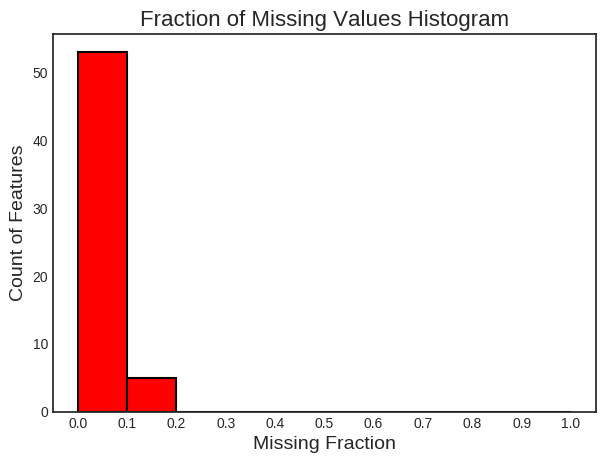

In [78]:
missing_features = fs.ops['missing']
fs.plot_missing()

In [79]:
fs.identify_single_unique()

1 features with a single unique value.



In [80]:
single_unique = fs.ops['single_unique']
single_unique

['Shared']

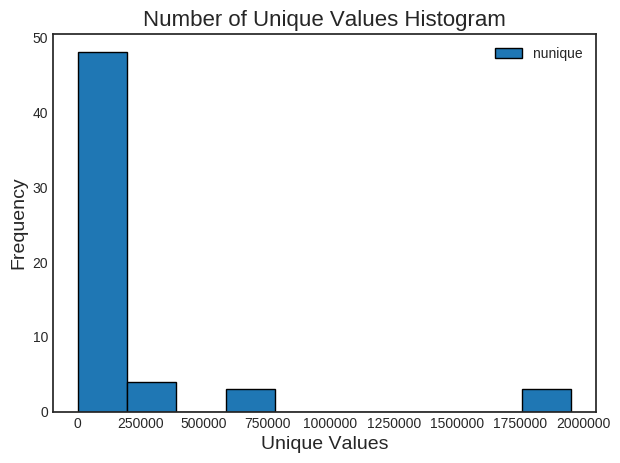

In [81]:
fs.plot_unique()

In [82]:
fs.identify_collinear(correlation_threshold=0.975)

6 features with a correlation magnitude greater than 0.97.



In [83]:
correlated_features = fs.ops['collinear']
correlated_features

['IncomingTrackId',
 'KOverSpeed',
 'KAcceleration',
 'KDeceleration',
 'KPhoneUsage',
 'EcoScoringBrakes']

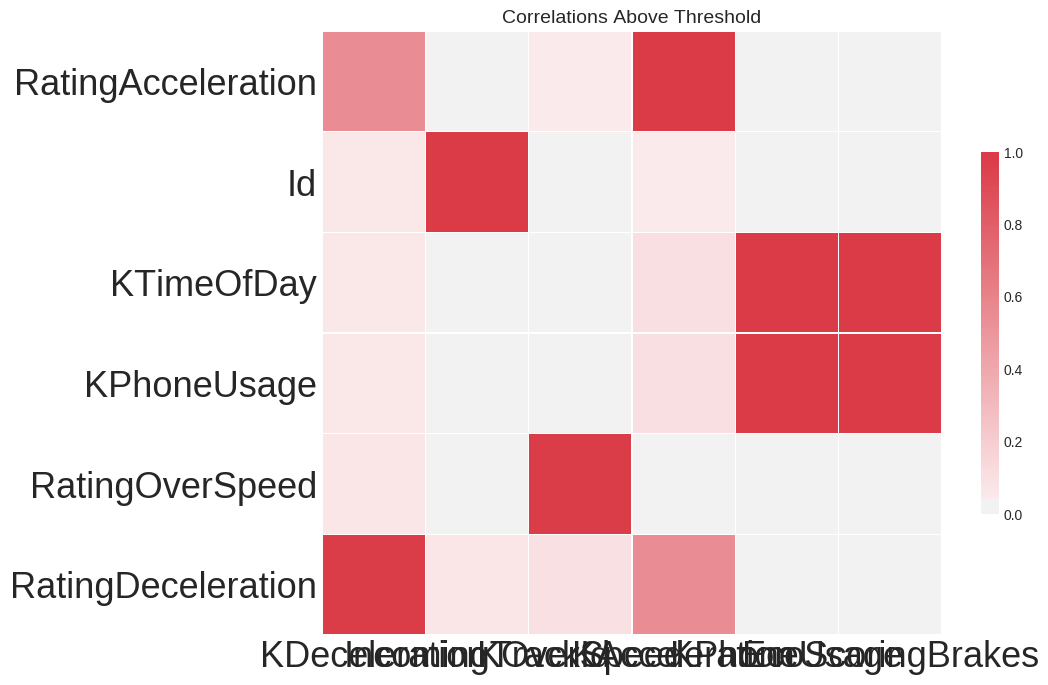

In [84]:
fs.plot_collinear()

We can view a heatmap of the correlations above the threshold. The features which will be dropped are on the x-axis.

In [85]:
fs.record_collinear

,drop_feature,corr_feature,corr_value
0,IncomingTrackId,Id,0.996804
1,KOverSpeed,RatingOverSpeed,0.990878
2,KAcceleration,RatingAcceleration,0.992855
3,KDeceleration,RatingDeceleration,0.989283
4,KPhoneUsage,KTimeOfDay,1.000000
5,EcoScoringBrakes,KTimeOfDay,1.000000
6,EcoScoringBrakes,KPhoneUsage,1.000000


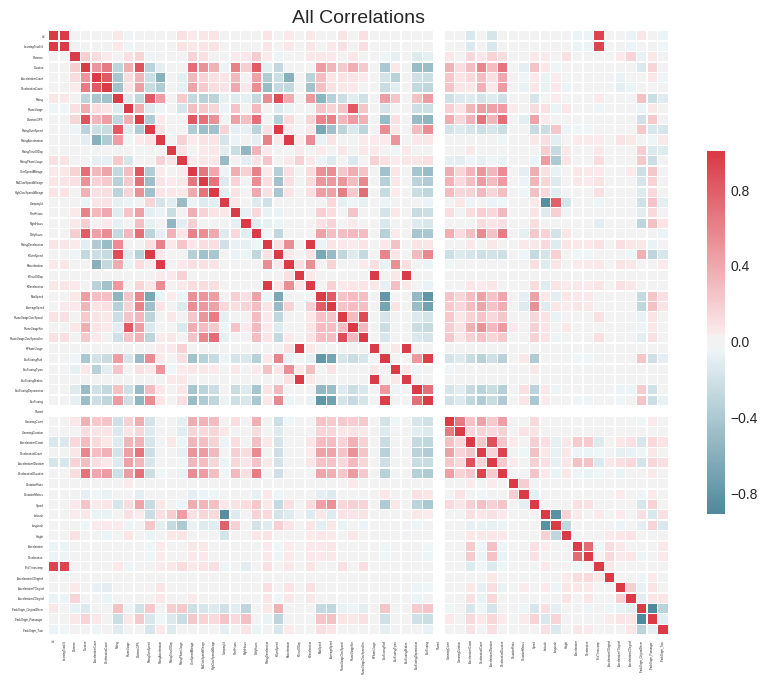

In [86]:
fs.plot_collinear(plot_all=True)

Once we have identified the features to remove, we have to `drop` them


In [87]:
newdf = data.drop(columns=['Shared', 
                            'IncomingTrackId',
                            'KOverSpeed',
                            'KAcceleration',
                            'KDeceleration',
                            'KPhoneUsage',
                            'EcoScoringBrakes',
                            ])
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3791240 entries, 0 to 3791239
Data columns (total 64 columns):
Id                        int64
TrackToken                object
DeviceToken               object
StartDate                 object
EndDate                   object
Distance                  float64
Duration                  float64
AccelerationCount         int64
DecelerationCount         int64
Rating                    float64
PhoneUsage                float64
TrackOrigin               object
OriginChanged             bool
AddressStart              object
AddressFinish             object
DistanceGPS               float64
Urban                     bool
Region                    object
Country                   object
RatingOverSpeed           float64
RatingAcceleration        float64
RatingTimeOfDay           float64
RatingPhoneUsage          float64
OverSpeedMileage          float64
MidOverSpeedMileage       float64
HighOverSpeedMileage      float64
CompanyId               

In [0]:
label_encoder = LabelEncoder()
cat_list = ['TrackOrigin']
labelenc = newdf[cat_list]

In [89]:
for column in labelenc:
     labelenc.replace({'OriginalDriver': 0, 'Taxi': 0,'Passanger': 1})
     newdf[column] = label_encoder.fit_transform(newdf[column])
label_encoder.classes_

array(['OriginalDriver', 'Passanger', 'Taxi'], dtype=object)

In [0]:
cats = ['object','bool']

In [91]:
ohe = newdf.select_dtypes(include = cats)
ohe.head()

,TrackToken,DeviceToken,StartDate,EndDate,OriginChanged,AddressStart,AddressFinish,Urban,Region,Country,CityStart,CityFinish,UpdateDT,os,PointDate
0,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,False,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",True,Республика Татарстан,Россия,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,iOS,2019-10-17 15:35:23.0000000 +03:00
1,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,False,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",True,Республика Татарстан,Россия,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,iOS,2019-10-17 15:35:23.0000000 +03:00
2,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,False,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",True,Республика Татарстан,Россия,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,iOS,2019-10-17 15:35:34.0000000 +03:00
3,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,False,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",True,Республика Татарстан,Россия,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,iOS,2019-10-17 15:35:34.0000000 +03:00
4,AB70A2A9-B45C-453D-B07C-C2D9E9D7442B,3E045058-A9A5-4442-A2CC-605B871C4B2C,2019-10-17 15:35:34.0000000 +03:00,2019-10-17 15:46:05.0000000 +03:00,False,"Тойминская улица 11А, Менделеевск, Менделеевск...","Сосновая улица 4, Менделеевск, Менделеевский р...",True,Республика Татарстан,Россия,Менделеевский район,Менделеевский район,2019-10-17 15:01:40.393,iOS,2019-10-17 15:35:34.0000000 +03:00


In [0]:
newdf = newdf.select_dtypes(include=numerics)

In [96]:
newdf = newdf.groupby('Id').mean().reset_index()

y = newdf['TrackOrigin'].values
newdf = newdf.drop(columns=['TrackOrigin'])
y

array([1., 1., 1., ..., 1., 1., 1.])

In [97]:
newdf.head()

,Id,Distance,Duration,AccelerationCount,DecelerationCount,Rating,PhoneUsage,DistanceGPS,RatingOverSpeed,RatingAcceleration,RatingTimeOfDay,RatingPhoneUsage,OverSpeedMileage,MidOverSpeedMileage,HighOverSpeedMileage,CompanyId,RushHours,NightHours,DailyHours,RatingDeceleration,KTimeOfDay,MaxSpeed,AverageSpeed,PhoneUsageOverSpeed,PhoneUsageKm,PhoneUsageOverSpeedKm,EcoScoringFuel,EcoScoringTyres,EcoScoringDepreciation,EcoScoring,CorneringCount,CorneringDuration,AccelerationICount,DecelerationICount,AccelerationIDuration,DecelerationIDuration,DeviationRatio,DeviationMeters,Speed,Latitude,Longitude,Height,Acceleration,Deceleration,TickTimestamp,AccelerationXOriginal,AccelerationYOriginal,AccelerationZOriginal
0,5078359,330.561652,81.783333,0.0,0.0,2.0,0.333333,37.217,1.0,5.0,3.0,4.0,7.770,5.709,3.194,3129.0,81.783333,0.0,0.000000,5.00,NaN,93.615631,34.603700,0.0,0.046,0.0,0.0,100.0,25.0,17.500000,0.0,0.0,57.0,30.0,311.0,183.0,0.0,63.061865,23.292324,-37.816831,145.006032,47944.457248,0.046806,0.459169,1.570817e+09,-0.172045,1.715661,8.277333
1,5078535,4.707325,24.383333,0.0,0.0,4.0,0.316667,4.285,5.0,5.0,3.0,4.0,0.333,0.000,0.000,3129.0,24.383333,0.0,0.000000,5.00,NaN,61.451141,27.206699,0.0,0.003,0.0,100.0,100.0,50.0,85.000008,0.0,0.0,13.0,11.0,339.0,51.0,0.0,93.016231,10.610393,-37.780908,144.878396,42102.960080,0.023560,0.231124,1.570822e+09,0.673712,-2.371338,5.382574
2,5078643,1.032507,1.683333,0.0,0.0,5.0,0.000000,1.043,5.0,5.0,3.0,5.0,0.000,0.000,0.000,3129.0,1.683333,0.0,0.000000,5.00,NaN,56.129097,36.989858,0.0,0.000,0.0,100.0,100.0,50.0,85.000008,0.0,0.0,45.0,0.0,56.0,0.0,0.0,1.645726,9.988912,-33.730152,151.033522,156913.737624,0.000000,0.000000,1.570786e+09,-0.391479,-0.142500,-0.217251
3,5078815,15.776025,18.183333,6.0,7.0,3.0,0.000000,15.628,4.0,1.0,5.0,5.0,5.789,0.371,0.030,3129.0,0.000000,0.0,18.183332,1.00,NaN,104.835564,60.314566,0.0,0.000,0.0,0.0,25.0,0.0,6.250000,0.0,0.0,5.0,9.0,8.0,16.0,0.0,4.992488,37.824928,-31.987934,115.920068,11505.090546,0.000000,0.000000,1.570421e+09,0.046761,-0.856863,-0.262711
4,5078995,8.696825,24.050000,0.0,1.0,4.8,1.166667,8.750,5.0,5.0,5.0,5.0,1.022,0.481,0.000,1061.0,0.000000,0.0,24.049999,3.93,1.0,76.031998,32.862011,0.0,0.440,0.0,100.0,100.0,0.0,70.000000,0.0,0.0,23.0,66.0,31.0,73.0,0.0,7.291171,17.821795,45.082982,38.980440,33240.998301,0.000000,0.000000,1.570784e+09,0.365235,-0.020190,0.101735


In [0]:
newdf = newdf.fillna(0)

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(newdf, y, test_size=0.3, random_state=42, shuffle=True)

In [0]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [106]:
model_dict = {
   'lr': LinearRegression(),
   'lasso': Lasso(random_state=42),
   'ridge': Ridge(random_state=42),
   'enet': ElasticNet(random_state=42),
   'knn': KNeighborsRegressor(),
   'dt': DecisionTreeRegressor(random_state=42),
   'rf': RandomForestRegressor(random_state=42)
}

score_list = []

for model in model_dict:
    model_dict[model].fit(X_train_scaled, y_train)
    y_pred_train = model_dict[model].predict(X_train_scaled)
    y_pred_valid = model_dict[model].predict(X_valid_scaled)
    score_train = r2_score(y_train, y_pred_train)
    score_valid = r2_score(y_valid, y_pred_valid)
    score_list.append((score_train, score_valid))

for model, scores in zip(model_dict.keys(), score_list):
    print(f'{model}: \n\ttrain: {np.round(scores[0], 4)} \n\tvalid: {np.round(scores[1], 4)}')

lr: 
	train: 0.2979 
	valid: 0.2436
lasso: 
	train: 0.0 
	valid: -0.0001
ridge: 
	train: 0.296 
	valid: 0.2489
enet: 
	train: 0.0 
	valid: -0.0001
knn: 
	train: 0.6833 
	valid: 0.4293
dt: 
	train: 1.0 
	valid: 0.7995
rf: 
	train: 0.9756 
	valid: 0.852


The best result with data preprocessing is RandomForest
baseline R^2 = 0.852


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(newdf, y, test_size=0.3, random_state=42, shuffle=True)

In [0]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Configure hyperparameters of the model using RandomizedSearchCV

In [109]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

random_grid = {
    'n_estimators': np.arange(200, 501, 20),
    'max_depth': np.arange(2, 51, 2),
    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=50,
    scoring='r2',
    cv=10,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

print(random_search.best_score_)
print(random_search.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] n_estimators=260, min_samples_split=2, min_samples_leaf=4, max_features=0.9, max_depth=44 
[CV] n_estimators=260, min_samples_split=2, min_samples_leaf=4, max_features=0.9, max_depth=44 
[CV] n_estimators=260, min_samples_split=2, min_samples_leaf=4, max_features=0.9, max_depth=44 
[CV] n_estimators=260, min_samples_split=2, min_samples_leaf=4, max_features=0.9, max_depth=44 
[CV]  n_estimators=260, min_samples_split=2, min_samples_leaf=4, max_features=0.9, max_depth=44, total=   4.6s
[CV] n_estimators=260, min_samples_split=2, min_samples_leaf=4, max_features=0.9, max_depth=44 
[CV]  n_estimators=260, min_samples_split=2, min_samples_leaf=4, max_features=0.9, max_depth=44, total=   4.8s
[CV] n_estimators=260, min_samples_split=2, min_samples_leaf=4, max_features=0.9, max_depth=44 
[CV]  n_estimators=260, min_samples_split=2, min_samples_leaf=4, max_features=0.9, max_depth=44, total=   4.8s
[CV]  n_estimators=260, min_

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   53.1s


[CV]  n_estimators=440, min_samples_split=2, min_samples_leaf=1, max_features=0.8, max_depth=34, total=   7.7s
[CV] n_estimators=440, min_samples_split=2, min_samples_leaf=1, max_features=0.8, max_depth=34 
[CV]  n_estimators=440, min_samples_split=2, min_samples_leaf=1, max_features=0.8, max_depth=34, total=   8.0s
[CV] n_estimators=440, min_samples_split=2, min_samples_leaf=1, max_features=0.8, max_depth=34 
[CV]  n_estimators=440, min_samples_split=2, min_samples_leaf=1, max_features=0.8, max_depth=34, total=   7.4s
[CV] n_estimators=280, min_samples_split=2, min_samples_leaf=2, max_features=0.8, max_depth=32 
[CV]  n_estimators=440, min_samples_split=2, min_samples_leaf=1, max_features=0.8, max_depth=34, total=   7.7s
[CV] n_estimators=280, min_samples_split=2, min_samples_leaf=2, max_features=0.8, max_depth=32 
[CV]  n_estimators=440, min_samples_split=2, min_samples_leaf=1, max_features=0.8, max_depth=34, total=   8.0s
[CV] n_estimators=280, min_samples_split=2, min_samples_leaf=

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.2min


[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=4, max_features=0.6, max_depth=16, total=   6.4s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=4, max_features=0.6, max_depth=16 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=4, max_features=0.6, max_depth=16, total=   6.6s
[CV] n_estimators=500, min_samples_split=5, min_samples_leaf=4, max_features=0.6, max_depth=16 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=4, max_features=0.6, max_depth=16, total=   6.8s
[CV] n_estimators=420, min_samples_split=2, min_samples_leaf=1, max_features=0.5, max_depth=16 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=4, max_features=0.6, max_depth=16, total=   6.4s
[CV] n_estimators=420, min_samples_split=2, min_samples_leaf=1, max_features=0.5, max_depth=16 
[CV]  n_estimators=500, min_samples_split=5, min_samples_leaf=4, max_features=0.6, max_depth=16, total=   6.8s
[CV] n_estimators=420, min_samples_split=2, min_samples_leaf=

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  7.9min


[CV]  n_estimators=460, min_samples_split=5, min_samples_leaf=1, max_features=0.6, max_depth=30, total=   6.7s
[CV] n_estimators=220, min_samples_split=10, min_samples_leaf=2, max_features=0.8, max_depth=24 
[CV]  n_estimators=460, min_samples_split=5, min_samples_leaf=1, max_features=0.6, max_depth=30, total=   6.6s
[CV] n_estimators=220, min_samples_split=10, min_samples_leaf=2, max_features=0.8, max_depth=24 
[CV]  n_estimators=220, min_samples_split=10, min_samples_leaf=2, max_features=0.8, max_depth=24, total=   4.1s
[CV] n_estimators=220, min_samples_split=10, min_samples_leaf=2, max_features=0.8, max_depth=24 
[CV]  n_estimators=460, min_samples_split=5, min_samples_leaf=1, max_features=0.6, max_depth=30, total=   6.6s
[CV] n_estimators=220, min_samples_split=10, min_samples_leaf=2, max_features=0.8, max_depth=24 
[CV]  n_estimators=220, min_samples_split=10, min_samples_leaf=2, max_features=0.8, max_depth=24, total=   3.5s
[CV] n_estimators=220, min_samples_split=10, min_sample

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.0min finished


0.8777752105833441
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.7, 'max_depth': 50}


Let's measure the wuality of the model by samples

In [110]:
y_pred_train = random_search.best_estimator_.predict(X_train_scaled)
y_pred_valid = random_search.best_estimator_.predict(X_valid_scaled)

score_train = r2_score(y_train, y_pred_train)
score_valid = r2_score(y_valid, y_pred_valid)

print(f'train: {np.round(score_train, 4)}\nvalid: {np.round(score_valid, 4)}')

train: 0.9849
valid: 0.883


In [112]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(newdf)

model = RandomForestRegressor(
    n_estimators=400,
    max_depth=26,
    max_features=0.5,
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

model.fit(X_scaled, y)

scores = cross_val_score(model, X_scaled, y, scoring='r2', cv=10, n_jobs=-1)

print(f'cv mean: {np.round(np.mean(scores), 4)}')
print(f'cv std:  {np.round(np.std(scores), 4)}')

cv mean: 0.1741
cv std:  0.2819


<div class="alert alert-block alert-green">
<h2> Finally, we can see that our model predicts very accurately.</h2>
</div>